# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

exclude = 35
Bk_all = np.delete(Bk_all, exclude, axis=0)
p_all = np.delete(p_all, exclude, axis=0)

### A few plotting routines

#### Experimental design

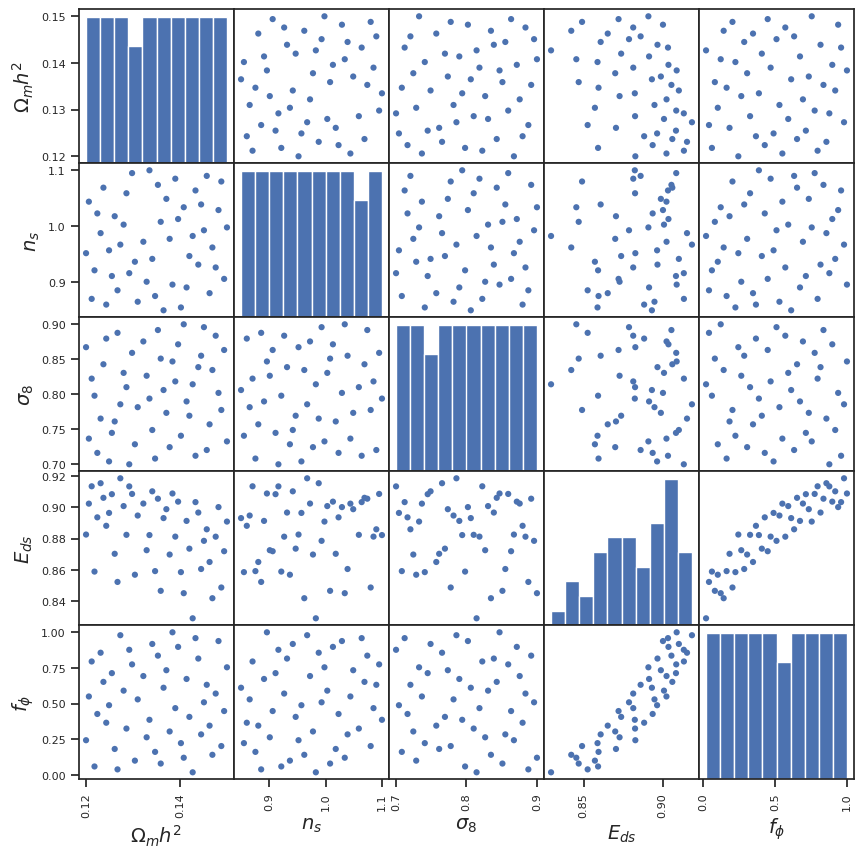

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

#### Boost metrics colored by cosmology parameters

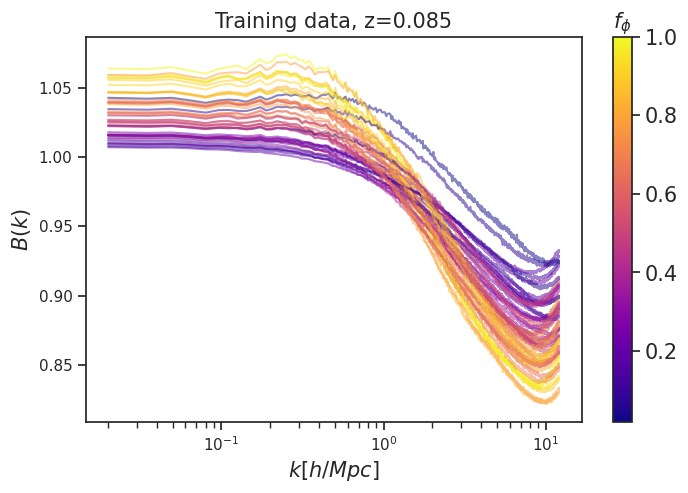

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

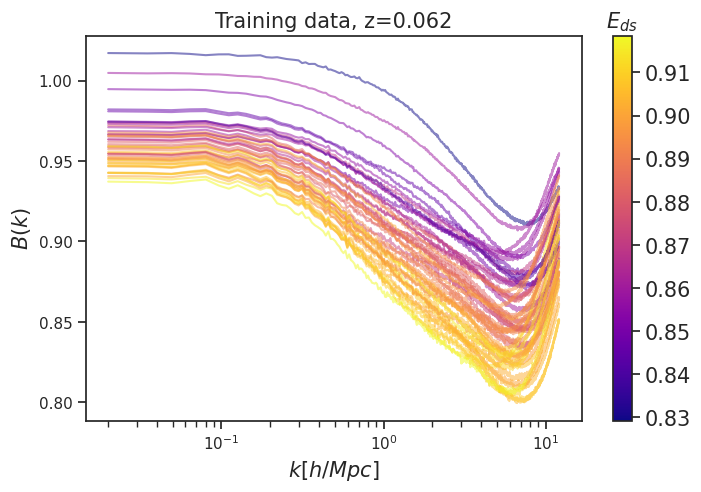

In [ ]:
color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

### Training involves: PCA, GP fitting.  

In [ ]:
## Data prep
z_index = 1
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all

# Train-test split
test_indices = [0, 14, 35]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(49) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = Bk_all[:, z_index, :][train_indices]

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.21it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.25965748 0.68905324]
 [0.53026066 0.48853502]
 [0.10919639 0.0814877 ]
 [0.23514907 0.24361992]
 [0.98081027 0.20397143]
 [0.05387494 2.18497831]]
lamUz
[[0.74106173 1.06917109]]
lamWs
[[5188.90350425 4856.98803313]]
lamWOs
[[4.87802565]]


MCMC sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.35it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl


### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

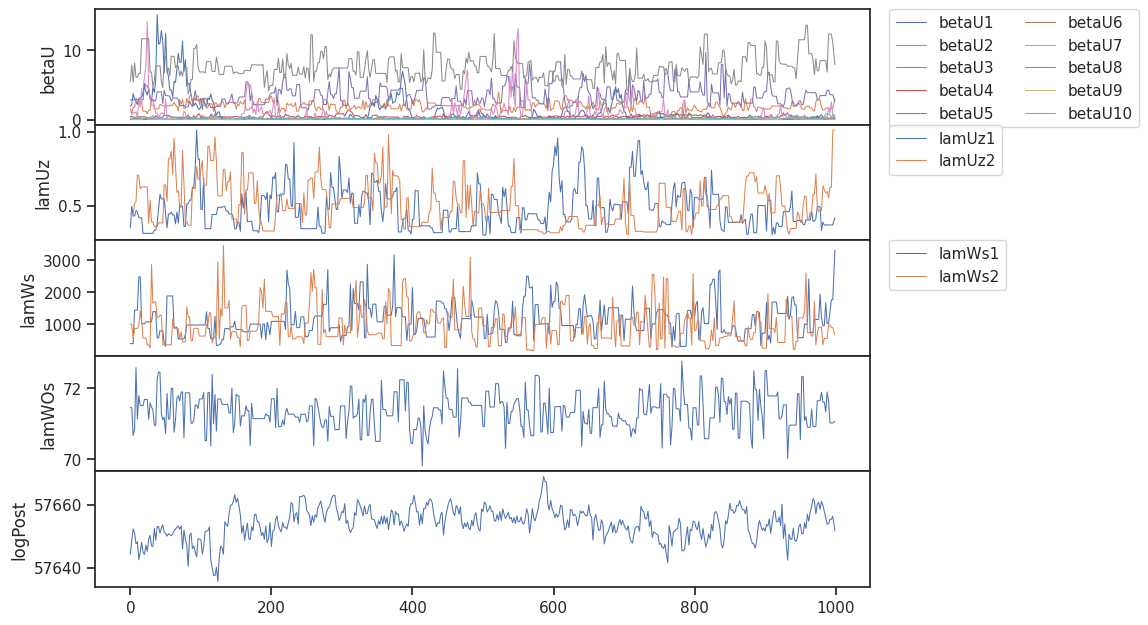

In [ ]:
plot_train_diagnostics(sepia_model)

### Single-redshift emulation for new cosmological parameters

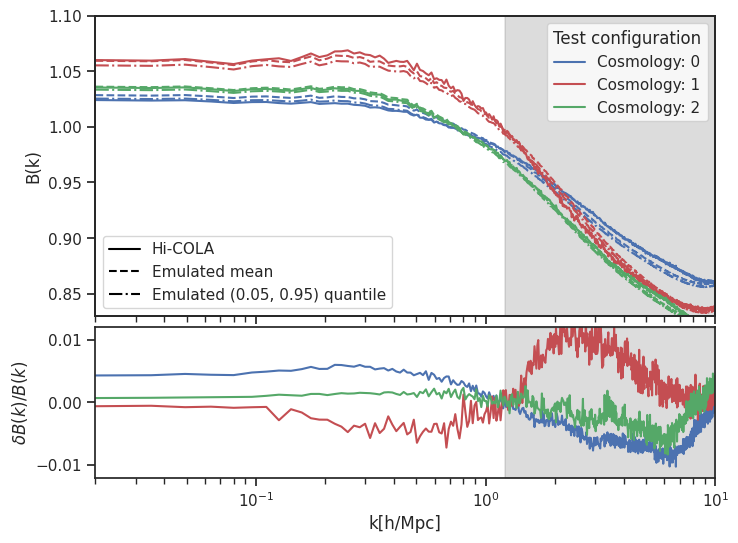

In [ ]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
validation_plot(k_all, target_vals, pred_mean, pred_quant);

### Sensitivity analysis from the emulator 

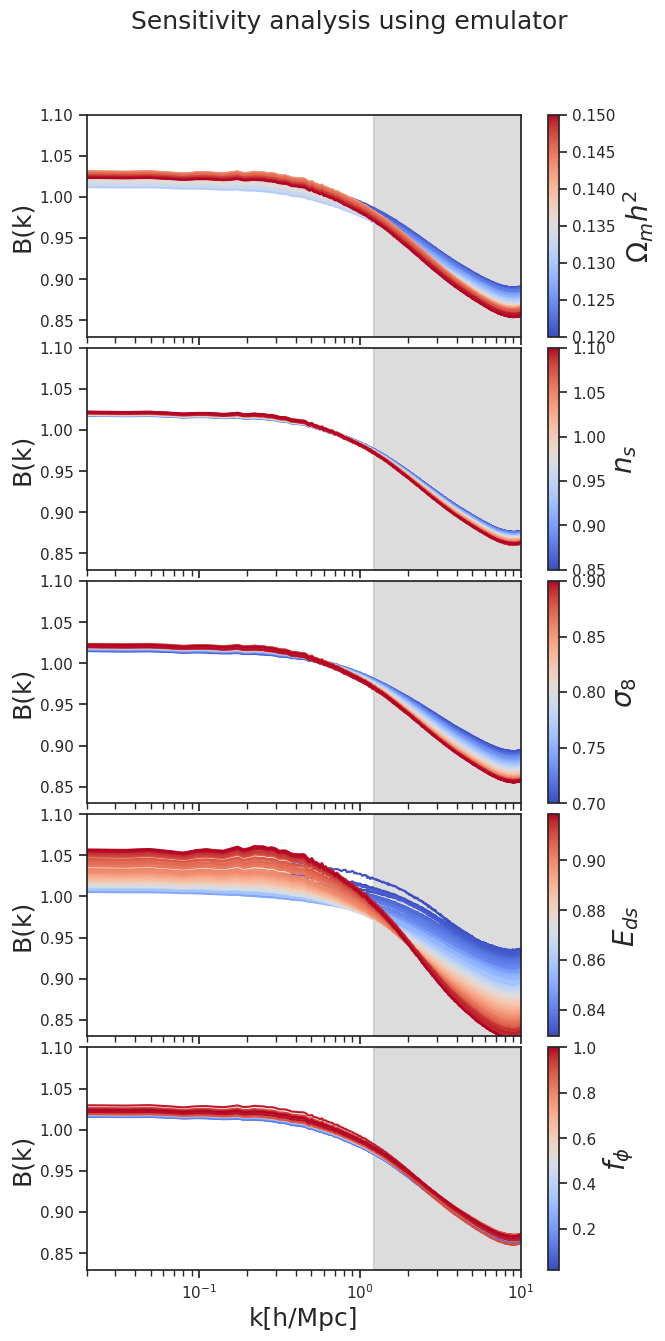

In [ ]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation (not part of the emulator yet)

#### Train all the models

In [ ]:
def do_gp_train_multiple(model_dir:str=None, # Pickle directory path
                         z_index_range:np.array=None, # Snapshot indices for training
                   ) -> None: 
    
    for z_index in z_index_range:
        y_vals = Bk_all[:, z_index, :]
        # y_ind = np.arange(0, y_vals.shape[1])
        y_ind = k_all
        
        p_all_train = p_all[train_indices]
        y_vals_train = Bk_all[:, z_index, :][train_indices]
        
        sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
        print(sepia_data)
        model_filename = model_dir + 'multivariate_model_z_index' + str(z_index) 


        sepia_model = do_pca(sepia_data, exp_variance=0.95)
        sepia_model = do_gp_train(sepia_model, model_filename)
        print('Training complete for snapshot ' + str(z_index))
        print('Model saved at ' + model_dir)
        print(30*'=*')
    
    return None

In [ ]:
do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', z_index_range=np.arange(50, 51))

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.35it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.75798572 0.45113576]
 [0.75417112 0.29826117]
 [0.050258   0.09857508]
 [0.09461339 0.49636579]
 [0.74048463 0.89082048]
 [0.13636869 0.08096501]]
lamUz
[[0.84522379 0.91930397]]
lamWs
[[2802.58496908  599.81483137]]
lamWOs
[[0.15272767]]


MCMC sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.22it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index50.pkl
Training complete for snapshot 50
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [ ]:
def load_model_multiple(model_dir:str=None, # Pickle directory path
                        z_index_range:np.array=None, # Snapshot indices for training
                        sepia_model_i:str=None,
                   ) -> None: 
    model_list = []
    
    for z_index in range(51):
        
        y_vals = Bk_all[:, z_index, :]
        # y_ind = np.arange(0, y_vals.shape[1])
        y_ind = k_all
        sepia_data = sepia_data_format(p_all, y_vals, y_ind)
        print(sepia_data)
        model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

        sepia_model_i = do_pca(sepia_data, exp_variance=0.95)
        
        
        model_filename = model_dir + 'multivariate_model_z_index' + str(z_index) 
        sepia_model_z = gp_load(sepia_model_i, model_filename)
        model_list.append(sepia_model_z)
        
    return model_list

In [ ]:
sepia_model_list = load_model_multiple(model_dir='../CubicGalileonEmu/model/', 
                                       z_index_range=np.arange(50, 51), 
                                  
                                       sepia_model_i=sepia_model)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (nu

In [ ]:
len(sepia_model_list)

51

In [ ]:
sepia_model_list

[<sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.SepiaModel.SepiaModel>,
 <sepia.

In [ ]:
def emu_redshift(input_params_and_redshift, sepia_model_list):
    
    z = input_params_and_redshift[:, -1]
    input_params = input_params_and_redshift[:, :-1]
    
    print(input_params.shape)
    print(z)
    
    '''
    if (z == 0):
        # No redshift interpolation for z=0
        GPm, PCAm = model_load(snap_ID=LAST_SNAP, nRankMax=DEFAULT_PCA_RANK)
        Pk_interp = emulate(sepia_model, input_params)
        
        
    else:
    '''
    
    # Linear interpolation between z1 < z < z2
    snap_idx_nearest = (np.abs(z_all - z)).argmin()
    if (z > z_all[snap_idx_nearest]):
        snap_ID_z1 = snap_idx_nearest - 1
    else:
        snap_ID_z1 = snap_idx_nearest
    snap_ID_z2 = snap_ID_z1 + 1
    
    print('SNAP ID: ', snap_ID_z1, snap_ID_z2)
    print('IP: ', input_params.shape)
    
    
    sepia_model_z1 = sepia_model_list[snap_ID_z1]
    Bk_z1, _ = emulate(sepia_model_z1, input_params)
    z1 = z_all[snap_ID_z1]
    

    sepia_model_z2 = sepia_model_list[snap_ID_z2]
    Bk_z2, _ = emulate(sepia_model_z2, input_params)
    z2 = z_all[snap_ID_z2]

    Bk_interp = np.zeros_like(Bk_z1)
    Bk_interp = Bk_z2 + (Bk_z1 - Bk_z2)*(z - z2)/(z1 - z2)
    
    return Bk_interp

In [ ]:
input_params0 = input_params[0]
z_inputs = 0.1234
input_params_and_redshift = np.append(input_params0, z_inputs)

In [ ]:
emr = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list)

(1, 5)
[0.1234]
SNAP ID:  2 3
IP:  (1, 5)


<matplotlib.legend.Legend>

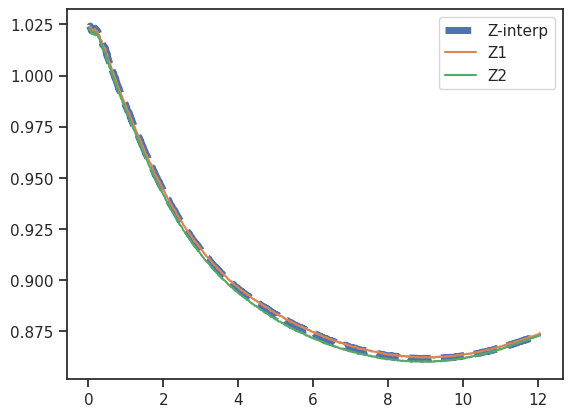

In [ ]:
plt.plot(k_all, emr[:, 0], label='Z-interp', lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[2], input_params_and_redshift[:-1])[0], label='Z1')
plt.plot(k_all, emulate(sepia_model_list[3], input_params_and_redshift[:-1])[0], label='Z2')
plt.legend()
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

In [ ]:
sepia_model_list[0]

<sepia.SepiaModel.SepiaModel>

### Parameter inference using the emulator (not implemented yet)